In [1]:
# data taken from: https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)
import numpy as np
from sklearn import preprocessing, neighbors
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
# getting the data
dataframe = pd.read_csv("breast-cancer-wisconsin.data")

# taking care of all 16 n/a values
dataframe.replace('?', -99999, inplace=True)

In [3]:
dataframe.head()

,id,clump_thickness,unif_cell_size,unif_cell_shape,marg_adhesion,single_epith_cell_size,bare_nuclei,bland_chrom,norm_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
dataframe.describe()


,id,clump_thickness,unif_cell_size,unif_cell_shape,marg_adhesion,single_epith_cell_size,bland_chrom,norm_nucleoli,mitoses,class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


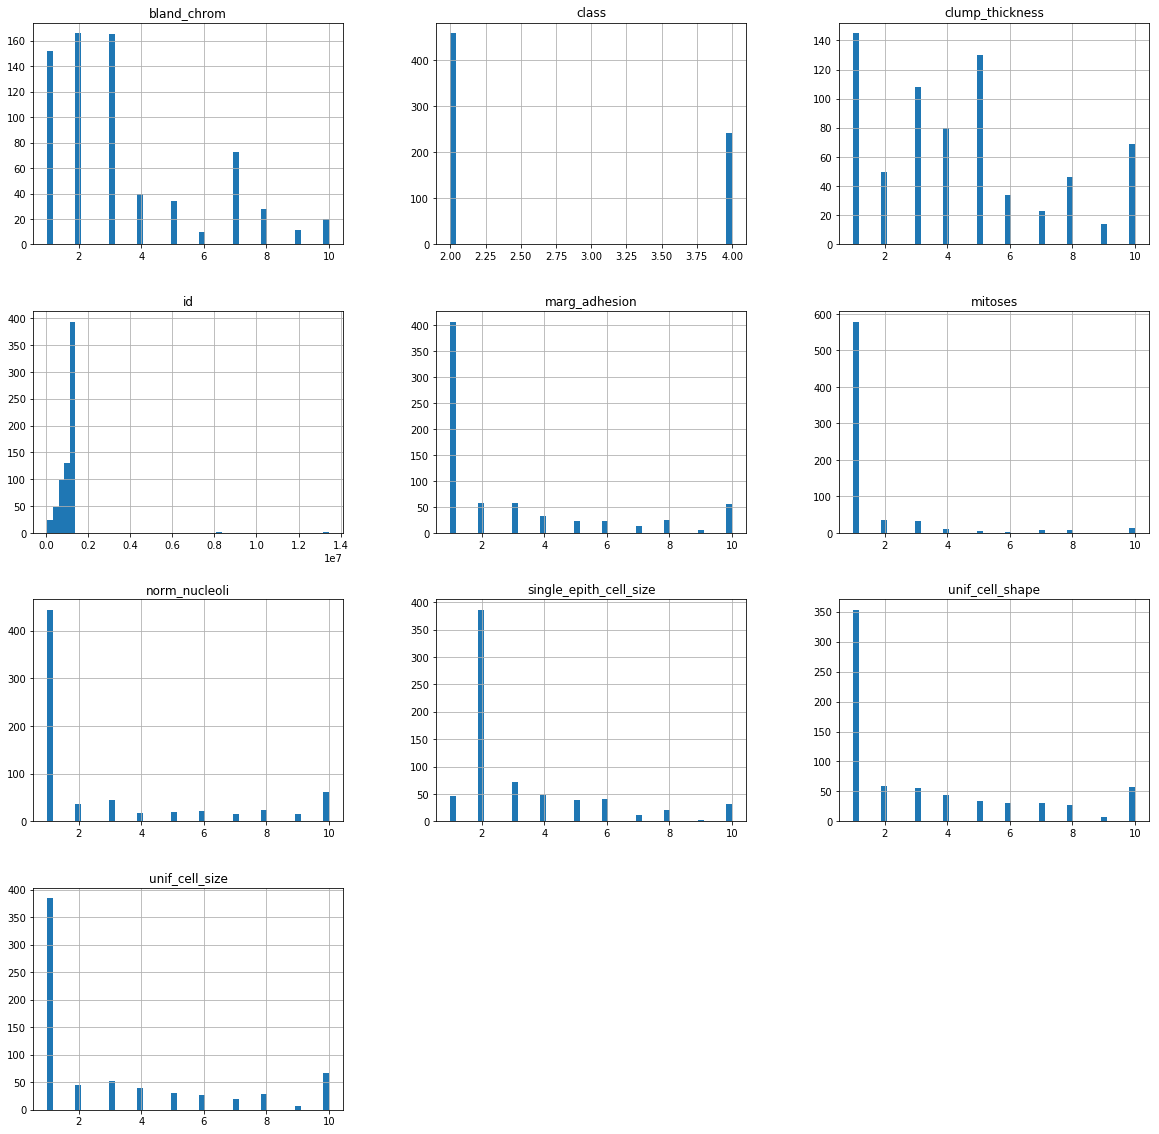

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
dataframe.hist(bins=50, figsize= (20, 20))
plt.show()

In [6]:
# looking for correlations
corr_matrix = dataframe.corr()
corr_matrix["class"].sort_values(ascending=False)

class                     1.000000
unif_cell_shape           0.818934
unif_cell_size            0.817904
bland_chrom               0.756616
clump_thickness           0.716001
norm_nucleoli             0.712244
marg_adhesion             0.696800
single_epith_cell_size    0.682785
mitoses                   0.423170
id                       -0.080226
Name: class, dtype: float64

In [7]:
# id is a completly random feature and it will ruin our model if we use it, so we get rid of it
dataframe.drop(['id'], 1, inplace=True)
# mitoses has the second lowest correlation value, but it's value is still high so I decided to leave it as a feature

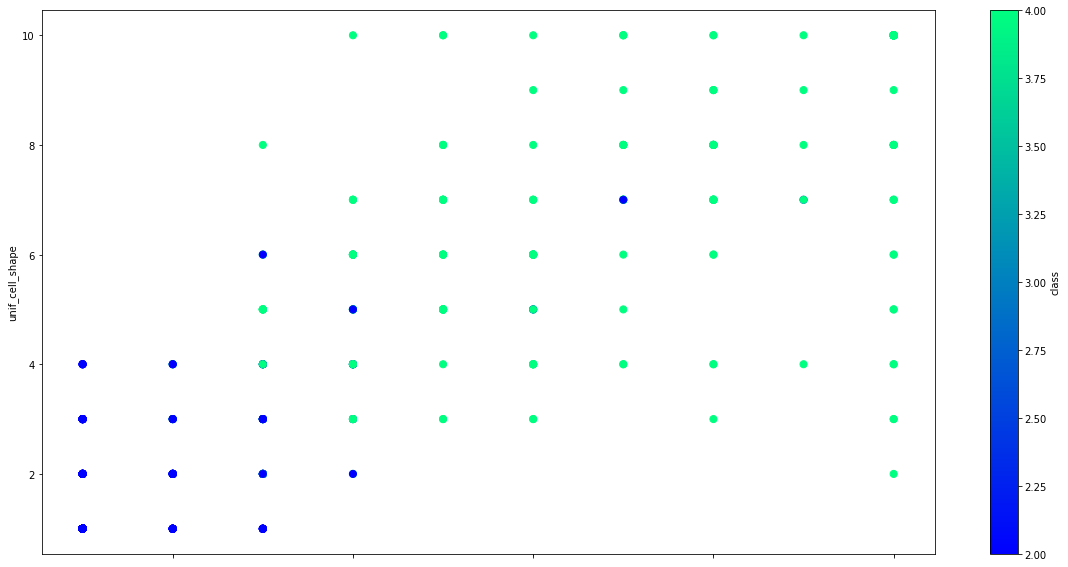

In [8]:
dataframe.plot(kind="scatter", x="unif_cell_size", y="unif_cell_shape", c="class", cmap=plt.get_cmap("winter"),
               figsize=(20,10), s=50)
plt.show()

In [9]:
# features
X = np.array(dataframe.drop(['class'], axis='columns'))

# labels
y = np.array(dataframe['class'])

In [10]:
# cross validation; we're using 80% of data to train our model and the remanign 20% is used to test it
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [11]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler() 
X_train = sc.fit_transform(X_train) 
X_test = sc.transform(X_test)

In [12]:
# creating the first classifier -> k-nearest neighbors
knearest = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto',
                                        leaf_size=30, p=2, metric='minkowski', metric_params=None)
knearest.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [13]:
# accuracy
def get_accuracy(classifier):
    acc = classifier.score(X_test, y_test)
    return acc

knearest_acc = get_accuracy(knearest)
print("accuracy of k-nearest: {}".format(knearest_acc))

accuracy of k-nearest: 0.95


In [14]:
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import cross_val_predict
# Measuring accuracy using the confusion matrix


# I could have predicted with the test set but we would have fewer results
# we're getting a 'clean' prediction for each instance in the training set
def get_confusion_matrix(classifier):
    # Predicting the Test set results
    
    #if we wanted to use the test set
    # y_pred = classifier.predict(X_test)
    # cm = confusion_matrix(y_test, y_pred)
    
    # cross_val_predict performs K-fold-cross-validation bit it returns the predictions made on each test fold
    # just as a reminder: K-fold-cross-validation slipts the training set randomly int K subsets
    # then it trains and evaluates the model K times, picking a different fold for evaluation each time
    # and training it on on the K-1 remaining folds
    y_pred = cross_val_predict(classifier, X_train, y_train, cv=3)
    cm = confusion_matrix(y_train, y_pred)
    
    return y_pred , cm

y_pred, knearest_cm = get_confusion_matrix(knearest)
print(knearest_cm)
# first row represents the negative class
# first row #col0 -> number of instances correctly predicted as benign (true negatives)
# first row #col1 -> number of instances wrongly classified as malicious (false positive)
# second row #col0 -> number of instances wrongly classified as benign (false negatives)
# second row #col1 -> number of instances correctly classified as malicious (true positives)
# a perfect classifier would have only true positives and true negatives
# so it would look like this (x and y being arbitrary values):
# [[x, 0],
# [0, y]]




[[358  12]
 [ 12 177]]


Confusion matrix, without normalization


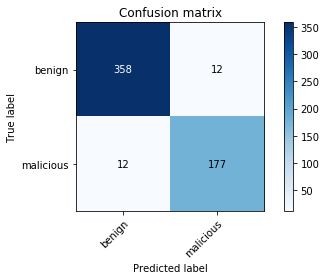

In [15]:
def plot_confusion_matrix(cm, y_test, y_pred, classes,
                          cmap=plt.cm.Blues):

    title = 'Confusion matrix'

    # Compute confusion matrix
    # cm = confusion_matrix(y_true, y_pred)
    # classes = classes[unique_y(y_test, y_pred)]
    print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(knearest_cm, y_test, y_pred, classes=["benign", "malicious"])

# Plot normalized confusion matrix
# plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      # title='Normalized confusion matrix')

plt.show()

In [16]:
# using Precision + Recall to measure accuracy
# precision = TP/(TP+FP)
# recall = TP/(TP+FN)

def get_precision_recall(cm):
    tp = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]

    ps = tp/(tp+fp)
    rs = tp/(tp+fn)
    
    return ps, rs

kn_precision, kn_recall = get_precision_recall(knearest_cm)

# precision score = accuracy of positive predictions 
print("precision score = {}".format(kn_precision))

# recall score = ratio of positive instances that are correctly detetected
print("recall score = {}".format(kn_recall))

precision score = 0.9675675675675676
recall score = 0.9675675675675676


In [17]:
# now to compare the results with the next classifier we have to calculate the F1 score using
# the precision and recall score
# the F1 score is the harmonic mean of precision and recall
# the harmonic mean favors much more weight to low values
F1_knearest = 2 * (kn_precision*kn_recall)/(kn_precision+kn_recall)
print("F1 score of k-nearest neighbors = {}".format(F1_knearest))

F1 score of k-nearest neighbors = 0.9675675675675676


In [18]:
# moving to SVM
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from scipy import stats

Cs = [0.001, 0.01, 0.1, 1, 10, 15, 20, 100, 1000]
gammas = [0.001, 0.01, 0.1, 1, 5, 10, 15, 20]
param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=10, iid=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)


{'C': 1, 'gamma': 0.1}


In [19]:
# Now we predict using SVM based on the grid search results

c = grid_search.best_params_['C']
g = grid_search.best_params_['gamma']

# using a Gaussian RBF kernel 
rbf_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=g, C=c, decision_function_shape='ovr'))
])

rbf_svm.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.1,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [20]:
# accuracy
acc_svm = get_accuracy(rbf_svm)
print("accuracy of svm: {}".format(acc_svm))

accuracy of svm: 0.9571428571428572


Confusion Matrix: 
[[356  14]
 [  8 181]]
Confusion matrix, without normalization


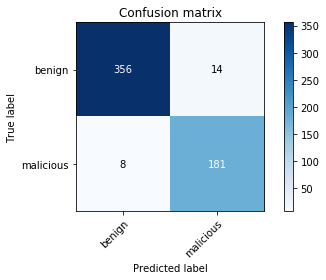

In [21]:
#y_pred = rbf_svm.predict(X_test) 
# Making the Confusion Matrix 
#cm = confusion_matrix(y_test, y_pred)

y_pred, svm_cm = get_confusion_matrix(rbf_svm)
print("Confusion Matrix: \n{}".format(svm_cm))

# Plot non-normalized confusion matrix
plot_confusion_matrix(svm_cm, y_test, y_pred, classes=["benign", "malicious"])

# Plot normalized confusion matrix
# plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      # title='Normalized confusion matrix')

plt.show()

In [22]:
svm_precision, svm_recall = get_precision_recall(svm_cm)

# precision score = accuracy of positive predictions 
print("precision score = {}".format(svm_precision))

# recall score = ratio of positive instances that are correctly detetected
print("recall score = {}".format(svm_recall))

precision score = 0.9621621621621622
recall score = 0.978021978021978


In [23]:
# now to compare the results with the next classifier we have to calculate the F1 score using
# the precision and recall score
# the F1 score is the harmonic mean of precision and recall
# the harmonic mean fives much more weight to low values
F1_svm = 2 * (svm_precision*svm_recall)/(svm_precision+svm_recall)
print("F1 score of svm: {}".format(F1_svm))

F1 score of svm: 0.9700272479564033


In [24]:
if(F1_svm > F1_knearest):
    print("svm performed better, with a F1 score of: {}".format(F1_svm))
    print("as opposed to the F1 score of k-nearest neighbors which was: {}".format(F1_knearest))
else:
    print("k-nearest neighbors performed better, with a F1 score of: {}".format(F1_knearest))
    print("as opposed to the F1 score of svm which was: {}".format(F1_svm))

svm performed better, with a F1 score of: 0.9700272479564033
as opposed to the F1 score of k-nearest neighbors which was: 0.9675675675675676
